# In this project a neural network is made, That can define the rotation of the object relative to the camera.

# Networks of this type can be used in many different ways,
# From manipulators on conveyor belts to self-driving cars and medicine.

# For this project i have desided to make a neural net that predicts the position of a pencil
# The net predicts 1 out of 8 posible rotations :
# Up, Up-Right, Right, Down-Right, Down, Down-Left, Left, Up-Left

In [24]:
import os
import cv2
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time
import statistics
from collections import Counter
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [2]:
# Load the dataset
root = 'C:/project'
train_data = pd.read_csv(os.path.join(root, 'Train.csv'))
test_data = pd.read_csv(os.path.join(root, 'Test.csv'))
class_names = {0:'up', 1:'up-right', 2:'right', 3:'down-right', 4:'down', 5:'down-left', 6:'left', 7:'up-left'}
num_classes = len(class_names)

In [3]:
num_train_samples = len(train_data)
num_test_samples = len(test_data)
# x_train - train images, y_train - classes for them
x_train = []
y_train = np.copy(train_data.iloc[:]['class'])
for i in range(0,num_train_samples) :
    img = cv2.imread(os.path.join(root, train_data.iloc[i]['path']))
    # Despite pictures being Gray, they are stored as RGB, so program deletes extra data
    img = img[:,:,0]
    x_train.append(img)

# x_test - validation images, y_test - classes for them
x_test = []
y_test = np.copy(test_data.iloc[:]['class'])
for i in range(0,num_test_samples) :
    img = cv2.imread(os.path.join(root, test_data.iloc[i]['path']))
    # Despite pictures being Gray, they are stored as RGB, so program deletes extra data
    img = img[:,:,0]
    x_test.append(img)

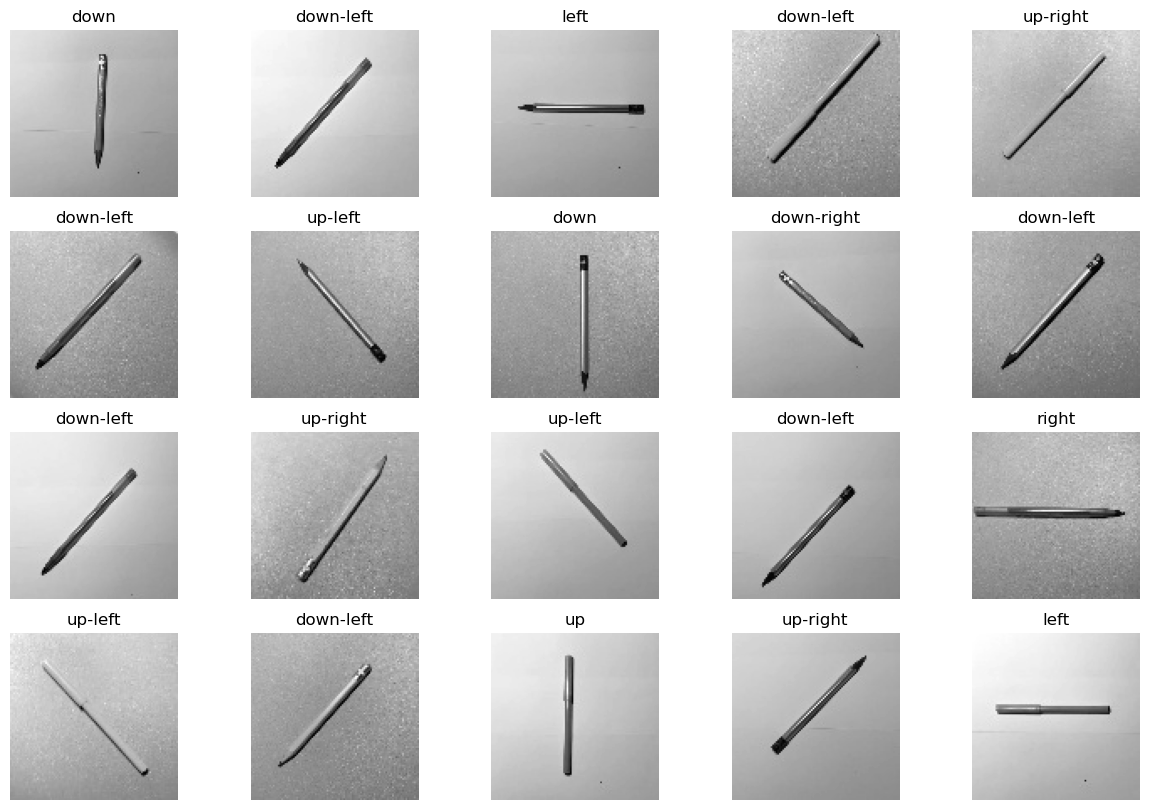

In [4]:
# Show random data samples
for ii in range(20):
    # Get random index
    idx = np.random.randint(0, num_train_samples)
    # Load image
    img = x_train[idx]
    # Show the image
    plt.subplot(4,5,ii+1), plt.imshow(img, cmap='gray'), plt.title(class_names[y_train[idx]]), plt.axis(False)

In [5]:
# Data normalization
x_train=np.copy(x_train)/255
x_test=np.copy(x_test)/255
# Converting variables to numpy variables, also getting size (which is known to be 100)
y_train=np.copy(y_train)
y_test=np.copy(y_test)
size = x_train.shape[1]

# A quick look at the dataset

Standard deviation : 15.779238733221575


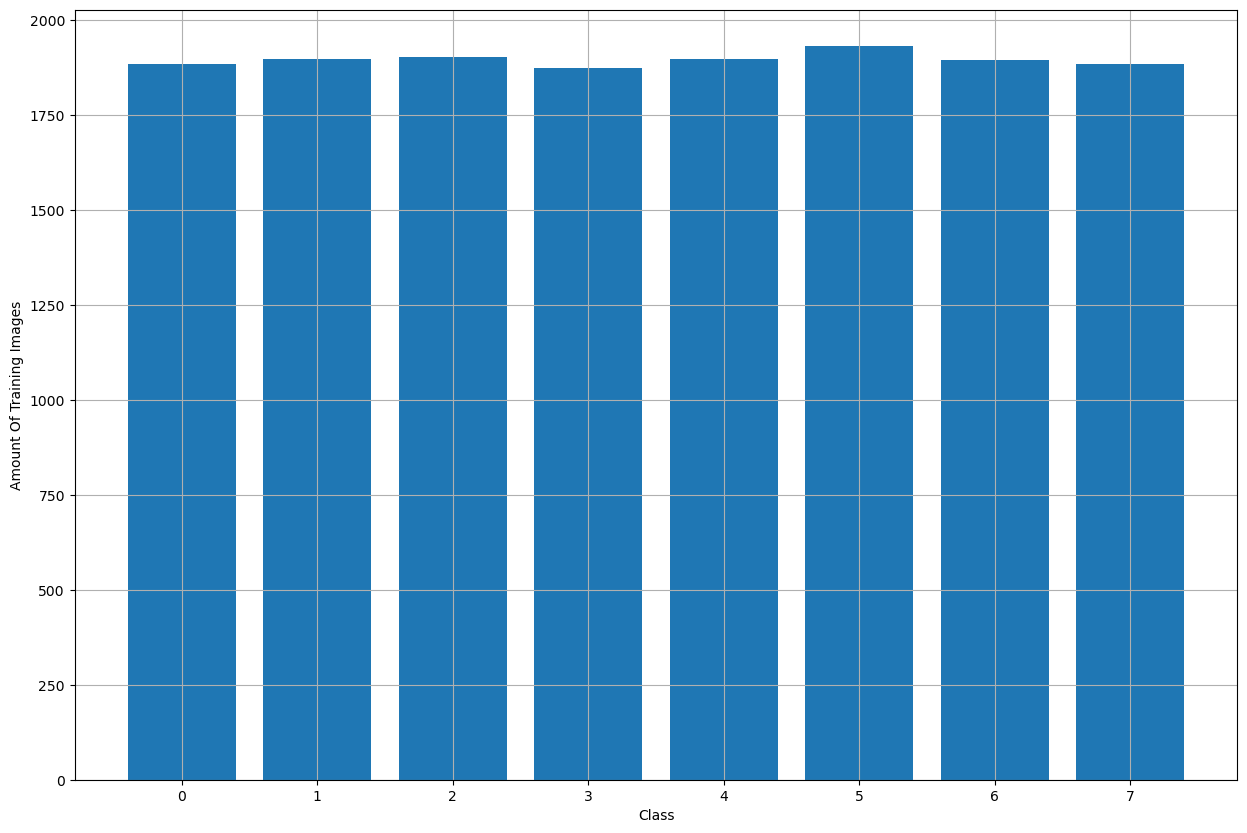

In [30]:
# Histogram of the amount of the training images
hist = Counter(y_train.flatten())

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xticks(range(0, num_classes))
plt.xlabel('Class'), plt.ylabel('Amount Of Training Images')
std = statistics.pstdev(hist.values())
print("Standard deviation :", std)

Standard deviation : 0.0


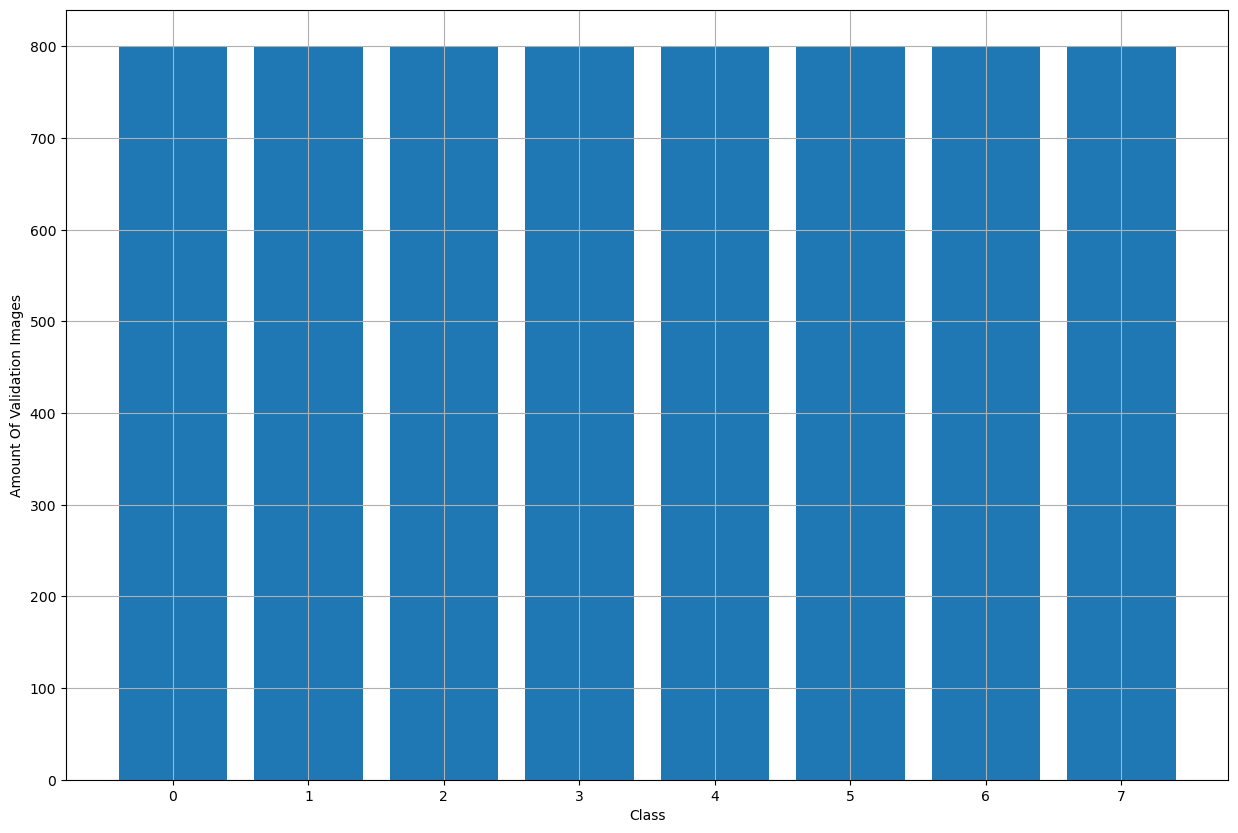

In [45]:
# Histogram of the amount of the validation images
hist = Counter(y_test.flatten())

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xticks(range(0, num_classes))
# For result evaluation. Getting the amount of pictures of each class
size_of_class = list(hist.values())
plt.xlabel('Class'), plt.ylabel('Amount Of Validation Images')
std = statistics.pstdev(hist.values())
# Validation sets are perfectly balanced
print("Standard deviation :", std)

# Creating the neural network

In [15]:
# A simple net
inputs = Input(shape=(size, size, 1))
net = Conv2D(40, kernel_size=(3,3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2,2))(net)
net = Dropout(0.1)(net)
net = Conv2D(40, kernel_size=(3,3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2,2))(net)
net = Dropout(0.1)(net)
net = Flatten()(net)
outputs = Dense(8, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 40)      400       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 40)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 50, 50, 40)        0         
                                                                 
 flatten_4 (Flatten)         (None, 100000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 800008    
                                                           

In [22]:
# Training it
# To avoid Overfitting, the amount of epochs was set to 5
epochs = 5
batch_size = 30

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/5
506/506 [==============================] - 81s 159ms/step - loss: 0.0112 - accuracy: 0.9981 - val_loss: 0.0368 - val_accuracy: 0.9880
Epoch 2/5
506/506 [==============================] - 76s 150ms/step - loss: 0.0091 - accuracy: 0.9985 - val_loss: 0.0300 - val_accuracy: 0.9902
Epoch 3/5
506/506 [==============================] - 63s 125ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.0298 - val_accuracy: 0.9916
Epoch 4/5
506/506 [==============================] - 72s 142ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.0299 - val_accuracy: 0.9914
Epoch 5/5
506/506 [==============================] - 62s 122ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9936


Train Acc      1.0
Validation Acc 0.9935937523841858


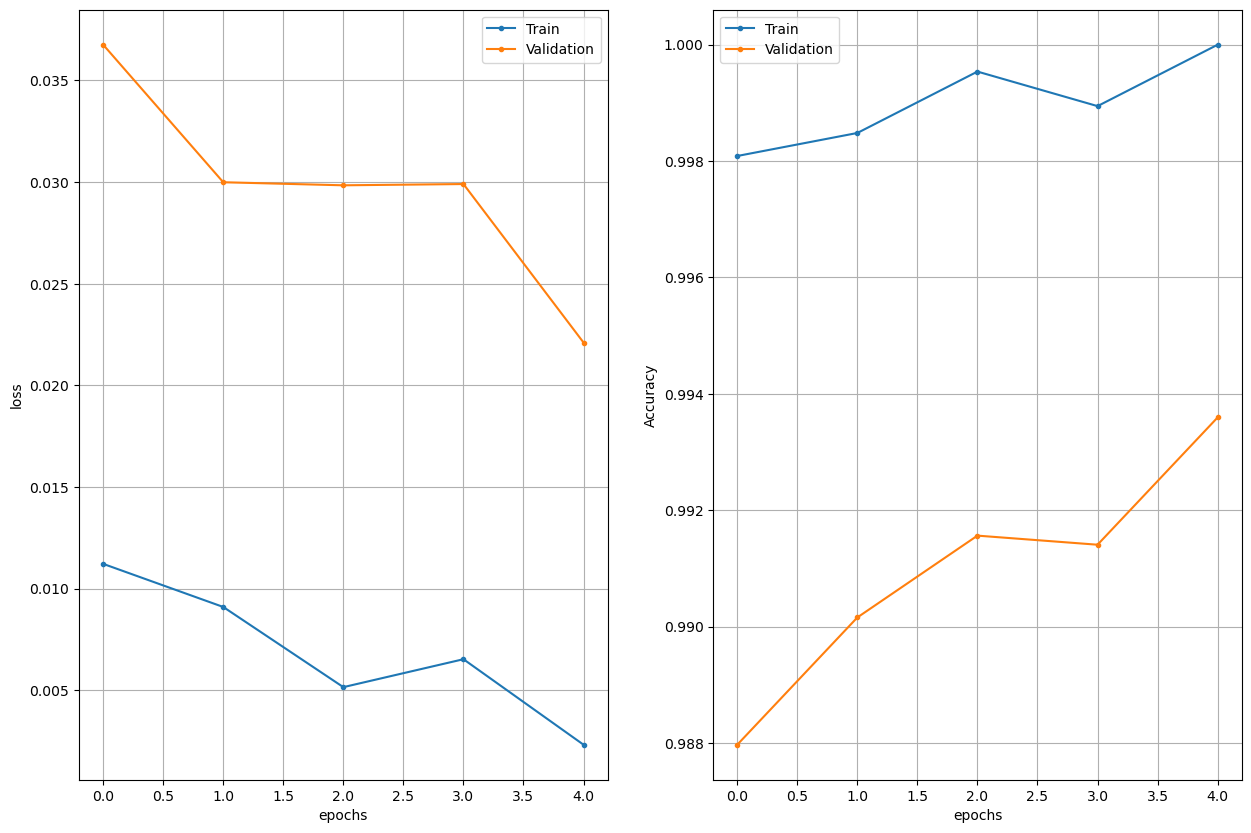

In [23]:
# Showing model history
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])  

# Results

In [38]:
# Getting predictions
predictions = model.predict(x_test)
y_pred = []
for i in range(0,predictions.shape[0]) :
    y_pred.append(np.argmax(predictions[i][:]))

200/200 [==============================] - 5s 27ms/step


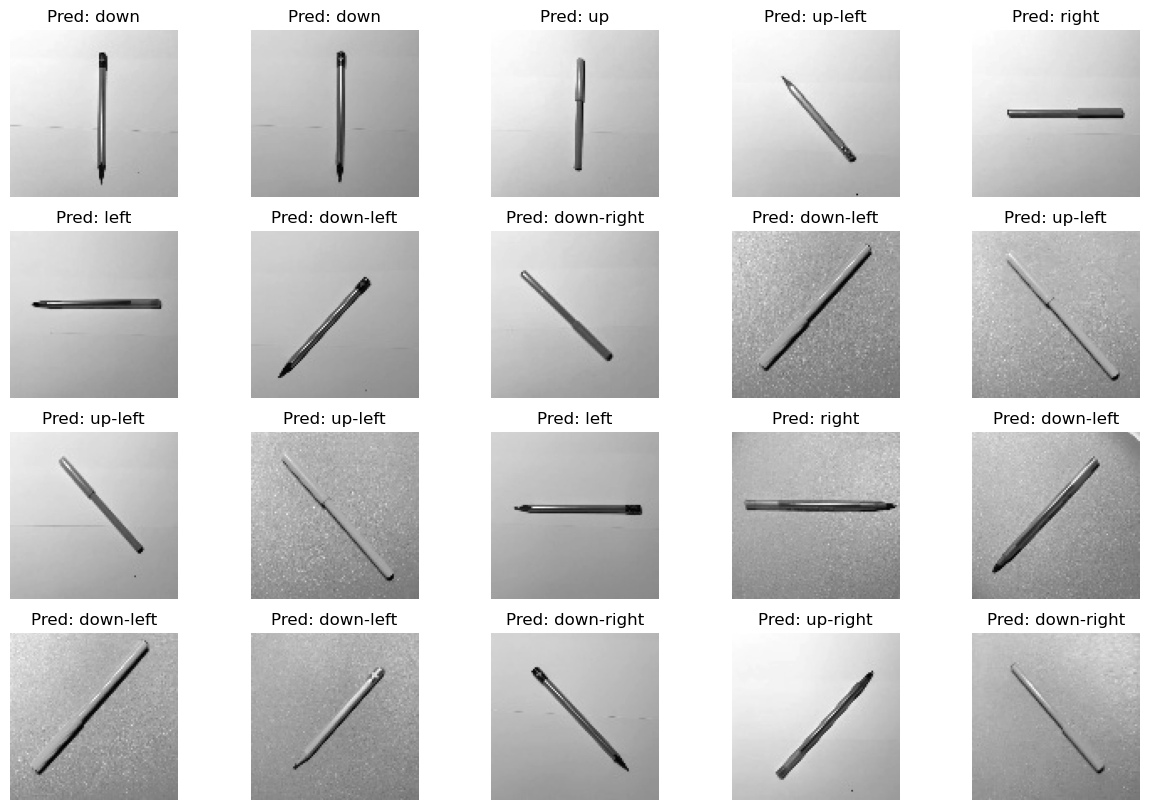

In [61]:
# Lets show random samples
for ii in range(20):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(4,5,ii+1), plt.imshow(x_test[idx, ...], cmap='gray'), plt.axis(False)
    plt.title('Pred: ' + str(class_names[y_pred[idx]]))

In [58]:
# Calculate and print the accuracy for each class
correct = np.zeros(num_classes)
for i in range(0,num_test_samples) :
    if y_pred[i] == y_test[i] :
        correct[y_test[i]]+=1

for class_id, class_name in class_names.items():
    acc = correct[class_id]/size_of_class[class_id]
    print(class_name,":", acc)

up : 0.995
up-right : 0.99125
right : 0.99125
down-right : 0.99875
down : 0.9975
down-left : 0.99
left : 0.9875
up-left : 0.9975


Standard deviation : 0.3874873989886639


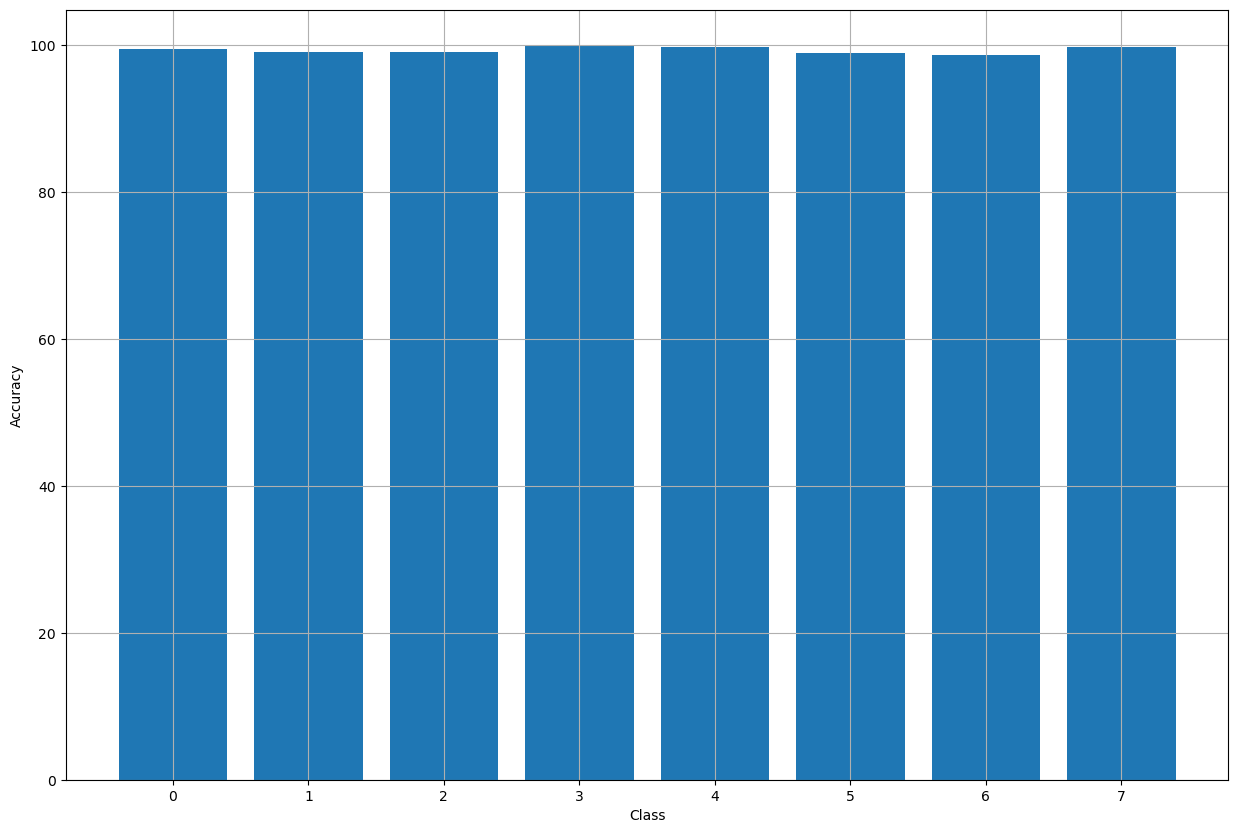

In [62]:
# And lets make a histogram out of them

plt.bar([0,1,2,3,4,5,6,7], correct[:]/size_of_class[:]*100), plt.grid(True)
plt.xticks(range(0, num_classes))
plt.xlabel('Class'), plt.ylabel('Accuracy')
std = statistics.pstdev(correct[:]/size_of_class[:]*100)
print("Standard deviation :", std)

# Conclusions


# Possible improvements :
      1) More classes can be added.
         At the moment the net has 8 classes, which gives a 45 degree accuracy.
      2) Expand the dataset.
         At the moment the dataset has around 21500 images.
# Future work :
#     Make a net that creates a 3D bounding box. 
#     Out of that a very accurate prediction can be made.